# Multi-Objective Reservoir Optimization: 5 Objectives with Operational Smoothness

This notebook extends the 4-objective optimization by adding **operational smoothness** as a 5th objective.

---

## Motivation: Why Add Smoothness?

The original 4-objective optimization produces solutions with highly erratic month-to-month variability. While mathematically optimal, these solutions are **operationally unrealistic**:

- Real operators cannot implement wild release swings
- Downstream users need predictable water availability
- Infrastructure stress from rapid flow changes
- Regulatory constraints often mandate gradual changes

By adding smoothness as an explicit objective, we:
1. **Reveal the trade-off** between performance and operability
2. Let decision-makers **choose their smoothness level**
3. Generate solutions that are actually **implementable**

---

## Problem Overview (5 Objectives)

| Objective | Direction | What it measures |
|-----------|-----------|------------------|
| Hydropower | Maximize | Electricity generated at the turbine |
| City Flood | Minimize | Water spillage when flow exceeds city capacity |
| Irrigation Deficit | Minimize | Unmet water demand for agriculture |
| Thermal Deficit | Minimize | Unmet cooling water for power plant |
| **Op. Variability** | **Minimize** | **Combined release + allocation smoothness** |

### The 5th Objective: Operational Variability

The smoothness objective combines **two components**:

```
Operational Variability = Release Variability + Allocation Variability

where:
    Release Variability    = Σ|R(t) - R(t-1)|           (turbine flow changes)
    Allocation Variability = Σ|frac(t) - frac(t-1)|×100 (irrigation split changes)
```

This ensures the optimizer penalizes **both**:
1. Erratic reservoir releases (flow through turbine)
2. Erratic allocation between irrigation and thermal plant

Lower values = smoother, more operationally realistic solutions.

## Setup and Imports

Before we begin, let's import the necessary libraries:

| Library | Purpose |
|---------|---------|
| `numpy` | Numerical computations and array operations |
| `matplotlib` | Static visualizations (Pareto plots, time series) |
| `pandas` | Data manipulation for results analysis |
| `plotly` | Interactive visualizations (parallel coordinates) |
| `taqsim` | Water system simulation framework |
| `ctrl_freak` | Multi-objective optimization (NSGA-II) |
| `pymoo` | Hypervolume indicator for optimization quality |

The `taqsim` framework provides:
- **Node types**: Source, Storage, Demand, Splitter, PassThrough, Sink
- **Events**: Track water flow through the system (WaterStored, WaterSpilled, etc.)
- **Strategies**: Customizable rules for release and allocation decisions
- **Optimization**: Interface to genetic algorithms for parameter tuning

In [4]:
from dataclasses import dataclass
from typing import ClassVar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

from taqsim import (
    Demand,
    Edge,
    LossReason,
    Objective,
    Ordered,
    PassThrough,
    Sink,
    Source,
    Splitter,
    Storage,
    Strategy,
    TimeSeries,
    WaterSystem,
    lift,
    optimize,
)
from taqsim.node.events import (
    DeficitRecorded,
    WaterPassedThrough,
    WaterReceived,
    WaterSpilled,
    WaterStored,
)

TIMESTEPS = 120
SEED = 96530  # From exploration trial 0

## Time Series Generation

Generate realistic seasonal patterns for river inflows and demands:
- **Inflows**: Peak in summer (months 5-7), low in winter, with random variability and occasional extreme events
- **Irrigation demand**: Peak in summer growing season (months 6-8), zero in winter
- **Thermal demand**: Higher in summer (more cooling needed), relatively stable baseline

In [5]:
# Configuration from exploration trial 0
INFLOW_SCALE = 0.89
IRRIGATION_PEAK = 25.4
THERMAL_BASE = 24.1
CITY_CAPACITY = 41.0


def generate_inflows(n_years: int = 10, mean_annual: float = 100.0, seed: int = 42) -> list[float]:
    """Generate monthly river inflows with seasonal pattern and variability."""
    rng = np.random.default_rng(seed)
    seasonal = [0.5, 0.6, 0.8, 1.2, 1.6, 1.8, 1.5, 1.0, 0.7, 0.5, 0.4, 0.4]

    inflows = []
    for year in range(n_years):
        year_factor = rng.uniform(0.8, 1.2)
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.9, 1.1)
            extreme = 1.8 if rng.random() < 0.08 else 1.0
            inflows.append(mean_annual * s * year_factor * noise * extreme)
    return inflows


def generate_irrigation_demand(n_years: int = 10, peak_demand: float = 25.0, seed: int = 123) -> list[float]:
    """Generate monthly irrigation demand with growing season pattern."""
    rng = np.random.default_rng(seed)
    seasonal = [0.0, 0.0, 0.2, 0.6, 1.0, 1.4, 1.5, 1.2, 0.7, 0.2, 0.0, 0.0]

    demand = []
    for year in range(n_years):
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.9, 1.1)
            demand.append(peak_demand * s * noise)
    return demand


def generate_thermal_demand(n_years: int = 10, base_demand: float = 24.0, seed: int = 456) -> list[float]:
    """Generate thermal plant cooling demand - higher in summer when more cooling is needed."""
    rng = np.random.default_rng(seed)
    seasonal = [0.7, 0.7, 0.8, 0.9, 1.1, 1.3, 1.4, 1.3, 1.1, 0.9, 0.8, 0.7]

    demand = []
    for year in range(n_years):
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.95, 1.05)
            demand.append(base_demand * s * noise)
    return demand


inflows = generate_inflows(n_years=10, mean_annual=100.0 * INFLOW_SCALE, seed=SEED)
irrigation_demand = generate_irrigation_demand(n_years=10, peak_demand=IRRIGATION_PEAK, seed=SEED + 1)
thermal_demand = generate_thermal_demand(n_years=10, base_demand=THERMAL_BASE, seed=SEED + 2)

print(f"Generated {len(inflows)} timesteps of data")
print(f"Total inflow: {sum(inflows):.1f}, Mean: {np.mean(inflows):.1f}")
print(f"Total irrigation demand: {sum(irrigation_demand):.1f}, Mean: {np.mean(irrigation_demand):.1f}")
print(f"Total thermal demand: {sum(thermal_demand):.1f}, Mean: {np.mean(thermal_demand):.1f}")

Generated 120 timesteps of data
Total inflow: 10076.1, Mean: 84.0
Total irrigation demand: 1721.3, Mean: 14.3
Total thermal demand: 2830.0, Mean: 23.6


## Operating Strategies: The 72 Parameters

The optimizer doesn't control the water directly — it tunes **operating rules** that the reservoir follows during simulation. These rules have parameters that vary by month, creating seasonal adaptation.

### Understanding the Parameter Space

The optimizer searches through a **72-dimensional space**:

```
Total parameters = (5 SLOP params × 12 months) + (1 split param × 12 months) = 72
```

Each combination of 72 numbers represents a complete **operating policy** — a year-round strategy for how the reservoir should behave.

---

### Strategy 1: SLOP Release Rule (60 parameters)

**SLOP** = Storage Level Operating Policy. It decides how much water to release based on current storage level.

The release follows a **piecewise linear function** with three zones:

```
Release
   ↑
   |           ╱ Flood control zone (slope m2)
   |         ╱
   |--------w-------- Normal zone (constant release)
   |       ╱
   |     ╱ Conservation zone (slope m1)
   |   ╱
   +--h1----h2----→ Water Level (head)
```

| Parameter | Meaning | Typical Range |
|-----------|---------|---------------|
| `h1` | Low threshold — below this, conserve water | 20-100 m |
| `h2` | High threshold — above this, release extra | 20-100 m |
| `w` | Base release rate in normal zone | 0-80 units |
| `m1` | How aggressively to reduce release when low | 0.01-2.0 |
| `m2` | How aggressively to increase release when high | 0.01-2.0 |

**Why 60 parameters?** Each of these 5 values can be different for each month:
- January might have `w=30` (low release, conserve for dry season)
- July might have `w=55` (high release, manage flood inflows)

---

### Strategy 2: Seasonal Split Ratio (12 parameters)

The **splitter node** divides water between irrigation and thermal plant. The `irrigation_fraction` parameter (0.1 to 0.9) controls this split for each month:

| Month | If `irrigation_fraction = 0.7` |
|-------|--------------------------------|
| July (peak irrigation) | 70% → irrigation, 30% → thermal |
| January (no crops) | Could be set to 0.2 → 20% irrigation, 80% thermal |

This creates direct competition: **every drop sent to irrigation is unavailable for thermal cooling**.

In [6]:
def volume_to_head(
    volume: float, v_dead: float = 10.0, v_max: float = 150.0, h_dead: float = 20.0, h_max: float = 100.0
) -> float:
    """Convert reservoir volume to hydraulic head (water level)."""
    v_clamped = max(v_dead, min(v_max, volume))
    return h_dead + (v_clamped - v_dead) * (h_max - h_dead) / (v_max - v_dead)


@dataclass(frozen=True)
class SLOPRelease(Strategy):
    """Storage Level Operating Policy with time-varying monthly parameters."""

    __params__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")
    __bounds__: ClassVar[dict[str, tuple[float, float]]] = {
        "h1": (20.0, 100.0),
        "h2": (20.0, 100.0),
        "w": (0.0, 80.0),
        "m1": (0.01, 2.0),
        "m2": (0.01, 2.0),
    }
    __constraints__: ClassVar[tuple] = (Ordered(low="h1", high="h2"),)
    __time_varying__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")
    __cyclical__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")

    h1: tuple[float, ...] = (40.0,) * 12
    h2: tuple[float, ...] = (70.0,) * 12
    w: tuple[float, ...] = (40.0,) * 12
    m1: tuple[float, ...] = (0.5,) * 12
    m2: tuple[float, ...] = (0.8,) * 12

    def release(self, node: Storage, inflow: float, t: int, dt: float) -> float:
        head = volume_to_head(node.storage)
        month = t % 12

        h1_t = self.h1[month]
        h2_t = self.h2[month]
        w_t = self.w[month]
        m1_t = self.m1[month]
        m2_t = self.m2[month]

        # Piecewise linear SLOP policy
        if head < h1_t:
            # Conservation zone: reduce release linearly
            release = max(0.0, w_t - m1_t * (h1_t - head))
        elif head > h2_t:
            # Flood control zone: increase release linearly
            release = w_t + m2_t * (head - h2_t)
        else:
            # Normal zone: release at base rate
            release = w_t

        # Cannot release more than available (above dead storage)
        available = max(0.0, node.storage - node.dead_storage)
        return min(release * dt, available)


@dataclass(frozen=True)
class SeasonalRatio(Strategy):
    """Time-varying split ratio between irrigation and thermal plant."""

    __params__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)
    __bounds__: ClassVar[dict[str, tuple[float, float]]] = {"irrigation_fraction": (0.1, 0.9)}
    __time_varying__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)
    __cyclical__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)

    irrigation_fraction: tuple[float, ...] = (0.5,) * 12

    def split(self, node: Splitter, amount: float, t: int) -> dict[str, float]:
        frac = self.irrigation_fraction[t % 12]
        return {
            "irrigation": amount * frac,
            "thermal_plant": amount * (1.0 - frac),
        }


# Count optimizable parameters
slop_params = 5 * 12  # 5 params × 12 months
ratio_params = 1 * 12  # 1 param × 12 months
print(f"SLOP parameters: {slop_params}")
print(f"SeasonalRatio parameters: {ratio_params}")
print(f"Total optimizable parameters: {slop_params + ratio_params}")

SLOP parameters: 60
SeasonalRatio parameters: 12
Total optimizable parameters: 72


### Reservoir Characteristics

The reservoir converts **stored volume** to **hydraulic head** (water level), which determines:
1. **Hydropower potential**: Power = flow × head × efficiency
2. **SLOP release decisions**: Thresholds h1 and h2 are compared against head, not volume

The relationship is linear between dead storage and full capacity:

```
head = h_dead + (volume - v_dead) × (h_max - h_dead) / (v_max - v_dead)
```

**Key parameters:**
- **Dead storage (10 units)**: Water below this level cannot be released (sediment, intake structure)
- **Full capacity (150 units)**: Maximum storage before spillway overflow
- **Active storage (140 units)**: Usable range for operations

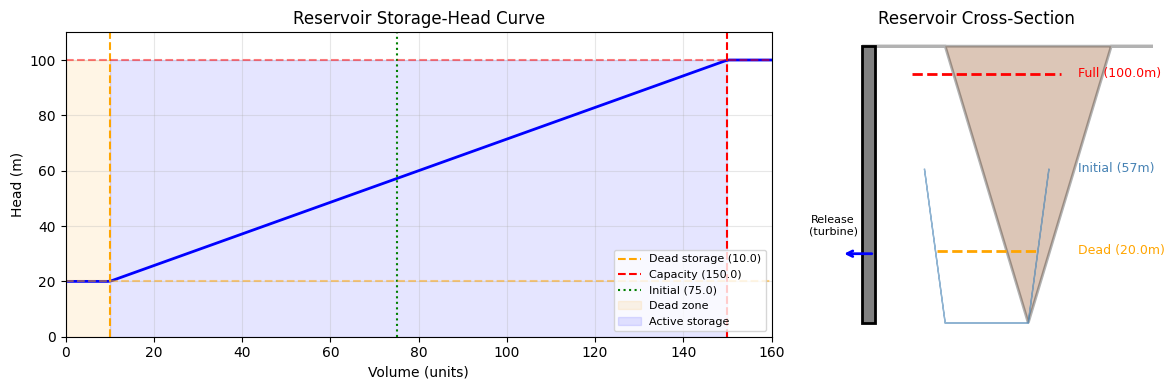

Reservoir characteristics:
  Dead storage: 10.0 units (head = 20.0m) - cannot release below this
  Full capacity: 150.0 units (head = 100.0m)
  Active storage: 140.0 units
  Initial storage: 75.0 units (head = 57.1m)


In [7]:
# Visualize reservoir volume-head relationship
fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})

# Reservoir parameters
V_DEAD = 10.0    # Dead storage (minimum operational volume)
V_MAX = 150.0    # Maximum capacity
H_DEAD = 20.0    # Head at dead storage
H_MAX = 100.0    # Head at full capacity
V_INITIAL = 75.0 # Initial storage

volumes = np.linspace(0, 160, 200)
heads = [volume_to_head(v, V_DEAD, V_MAX, H_DEAD, H_MAX) for v in volumes]

# Plot 1: Volume-Head curve (storage characteristic)
ax = axes[0]
ax.plot(volumes, heads, "b-", linewidth=2)
ax.axvline(x=V_DEAD, color="orange", linestyle="--", label=f"Dead storage ({V_DEAD})")
ax.axvline(x=V_MAX, color="red", linestyle="--", label=f"Capacity ({V_MAX})")
ax.axvline(x=V_INITIAL, color="green", linestyle=":", label=f"Initial ({V_INITIAL})")
ax.axhline(y=H_DEAD, color="orange", linestyle="--", alpha=0.5)
ax.axhline(y=H_MAX, color="red", linestyle="--", alpha=0.5)
ax.fill_between([0, V_DEAD], 0, H_MAX, alpha=0.1, color="orange", label="Dead zone")
ax.fill_between([V_DEAD, V_MAX], 0, H_MAX, alpha=0.1, color="blue", label="Active storage")
ax.set_xlabel("Volume (units)")
ax.set_ylabel("Head (m)")
ax.set_title("Reservoir Storage-Head Curve")
ax.legend(loc="lower right", fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 160)
ax.set_ylim(0, 110)

# Plot 2: Schematic cross-section of reservoir (scaled coordinates)
ax = axes[1]

# Draw reservoir basin (V-shape)
basin_x = [0, 2, 4, 6, 8]
basin_y = [100, 100, 0, 100, 100]
ax.fill(basin_x, basin_y, color="saddlebrown", edgecolor="black", linewidth=2, alpha=0.3)

# Water at current level
h_current_scaled = (volume_to_head(V_INITIAL) / H_MAX) * 80 + 10
h_dead_scaled = (H_DEAD / H_MAX) * 80 + 10
h_max_scaled = 90

# Calculate water polygon width at current level
water_width_factor = h_current_scaled / 100
water_x = [2 + (1 - water_width_factor) * 1, 2 + (1 - water_width_factor) * 1 + water_width_factor * 2, 
           4 - (1 - water_width_factor) * 1, 4 - (1 - water_width_factor) * 1 - water_width_factor * 2]
ax.fill([1.5, 2, 4, 4.5, 4.5, 4, 2, 1.5], 
        [h_current_scaled, 0, 0, h_current_scaled, h_current_scaled, 0, 0, h_current_scaled], 
        color="steelblue", alpha=0.6)

# Horizontal lines for water levels
ax.hlines(y=h_dead_scaled, xmin=1.8, xmax=4.2, color="orange", linestyle="--", linewidth=2)
ax.hlines(y=h_max_scaled, xmin=1.2, xmax=4.8, color="red", linestyle="--", linewidth=2)

# Labels
ax.text(5.2, h_dead_scaled, f"Dead ({H_DEAD}m)", fontsize=9, va="center", color="orange")
ax.text(5.2, h_max_scaled, f"Full ({H_MAX}m)", fontsize=9, va="center", color="red")
ax.text(5.2, h_current_scaled, f"Initial ({volume_to_head(V_INITIAL):.0f}m)", fontsize=9, va="center", color="steelblue")

# Dam wall
ax.fill([0, 0, 0.3, 0.3], [0, 100, 100, 0], color="gray", edgecolor="black", linewidth=2)

# Turbine outlet arrow
ax.annotate("", xy=(-0.5, 25), xytext=(0.3, 25), arrowprops=dict(arrowstyle="->", color="blue", lw=2))
ax.text(-0.7, 32, "Release\n(turbine)", fontsize=8, ha="center")

ax.set_xlim(-1.5, 7)
ax.set_ylim(-5, 105)
ax.axis("off")
ax.set_title("Reservoir Cross-Section")

plt.tight_layout()
plt.show()

print(f"Reservoir characteristics:")
print(f"  Dead storage: {V_DEAD} units (head = {H_DEAD}m) - cannot release below this")
print(f"  Full capacity: {V_MAX} units (head = {H_MAX}m)")
print(f"  Active storage: {V_MAX - V_DEAD} units")
print(f"  Initial storage: {V_INITIAL} units (head = {volume_to_head(V_INITIAL):.1f}m)")

## Objectives

We optimize four objectives that capture the key trade-offs in reservoir operations:

### 1. Hydropower (maximize)
Total electricity generated at the turbine over 120 months.

**Formula:** `Power = flow × head × efficiency × gravity`
- **flow**: Water passing through turbine (from reservoir release)
- **head**: Hydraulic head based on reservoir storage level

**Trade-off:** Wants high release for high flow, but excessive release depletes reservoir → lower head.

### 2. City Flood Risk (minimize)
Total water spillage at the city passthrough when flow exceeds capacity (41 units).

**Trade-off:** Wants low release to stay under capacity, directly conflicts with hydropower.

### 3. Irrigation Deficit (minimize)
Total unmet irrigation water demand over the simulation period.

**Trade-off:** Irrigation is fully consumptive (water doesn't return to system) and peaks in summer when inflows are highest but thermal demand also peaks.

### 4. Thermal Plant Deficit (minimize)
Total unmet cooling water demand for the thermal power plant.

**Trade-off:** Thermal demand is non-consumptive (water returns to system) but competes with irrigation for the same water allocation via the splitter.

---

**Key Trade-off:** The SeasonalRatio strategy controls how water is split between irrigation and thermal plant. More water to one means less to the other — creating a direct irrigation vs. thermal trade-off.

## Building the Water System

A water system in taqsim is a **directed graph** where:
- **Nodes** represent physical components (reservoir, turbine, demand points)
- **Edges** represent water conveyance (canals, pipes) with capacity limits

### Node Types Used

| Node Type | Purpose | Example in this system |
|-----------|---------|----------------------|
| `Source` | Water enters the system | River inflow |
| `Storage` | Holds water with release rule | Reservoir (capacity 150 units) |
| `PassThrough` | Conveys water with capacity limit | Turbine (60 units), City (41 units) |
| `Splitter` | Divides flow according to rule | Irrigation/Thermal split |
| `Demand` | Consumes water, records deficit | Irrigation, Thermal plant |
| `Sink` | Water exits the system | End points |

### System Topology

```
River → Reservoir → Turbine → City → Splitter → Irrigation → Sink
                                          ↓
                                    Thermal Plant → Sink
```

### Key Constraints

1. **City capacity (41 units)**: The bottleneck that causes flooding when exceeded
2. **Turbine capacity (60 units)**: Maximum flow through the powerhouse
3. **Irrigation consumption (100%)**: All water is consumed by crops (evapotranspiration)
4. **Thermal consumption (0%)**: Cooling water passes through and returns to the system

In [8]:
from taqsim.node.events import WaterReleased


@lift
def volume_to_head_lifted(v: float) -> float:
    """Lifted version for trace arithmetic."""
    return 20.0 + (max(10.0, min(150.0, v)) - 10.0) * 80.0 / 140.0


def hydropower_objective(
    reservoir_id: str, turbine_id: str, initial_storage: float = 75.0, efficiency: float = 0.85
) -> Objective:
    """Maximize hydropower generation using dynamic head."""

    def evaluate(system: WaterSystem) -> float:
        turbine = system.nodes[turbine_id]
        reservoir = system.nodes[reservoir_id]

        flow_trace = turbine.trace(WaterPassedThrough)
        stored_trace = reservoir.trace(WaterStored)
        released_trace = reservoir.trace(WaterReleased)

        net_change = stored_trace - released_trace
        storage_trace = net_change.cumsum(initial=initial_storage)
        head_trace = storage_trace.map(volume_to_head_lifted)

        power_trace = flow_trace * head_trace * (9810 * efficiency / 1e9)
        return power_trace.sum()

    return Objective(name="hydropower", direction="maximize", evaluate=evaluate)


def flood_objective(node_id: str) -> Objective:
    """Minimize flood risk (spillage) at a passthrough node."""

    def evaluate(system: WaterSystem) -> float:
        return system.nodes[node_id].trace(WaterSpilled).sum()

    return Objective(name="city_flood", direction="minimize", evaluate=evaluate)


def deficit_objective(node_id: str, name: str | None = None) -> Objective:
    """Minimize water deficit at a demand node."""

    def evaluate(system: WaterSystem) -> float:
        return system.nodes[node_id].trace(DeficitRecorded, field="deficit").sum()

    return Objective(name=name or f"{node_id}_deficit", direction="minimize", evaluate=evaluate)


def operational_variability_objective(
    turbine_id: str,
    irrigation_id: str,
    thermal_id: str,
    allocation_weight: float = 1.0,
) -> Objective:
    """Minimize total operational variability: release + allocation changes.
    
    This objective penalizes erratic operations by measuring:
        Σ|R(t) - R(t-1)|                           (release variability)
      + λ × Σ|irr(t)/total(t) - irr(t-1)/total(t-1)|  (allocation variability)
    
    where:
        - R(t) = turbine flow at timestep t
        - irr(t)/total(t) = fraction of water going to irrigation at timestep t
        - λ = allocation_weight (default 1.0, scales allocation term relative to release)
    
    Lower values indicate smoother, more operationally realistic patterns for BOTH
    release decisions AND allocation decisions.
    
    Args:
        turbine_id: ID of the turbine node (for release variability)
        irrigation_id: ID of the irrigation demand node
        thermal_id: ID of the thermal demand node
        allocation_weight: Weight for allocation variability relative to release (default 1.0)
    """

    def evaluate(system: WaterSystem) -> float:
        # === Release variability: Σ|R(t) - R(t-1)| ===
        turbine = system.nodes[turbine_id]
        flow_trace = turbine.trace(WaterPassedThrough)
        flows = np.array(flow_trace.values())
        
        release_var = 0.0
        if len(flows) >= 2:
            release_var = float(np.abs(np.diff(flows)).sum())
        
        # === Allocation variability: Σ|frac(t) - frac(t-1)| ===
        irrigation = system.nodes[irrigation_id]
        thermal = system.nodes[thermal_id]
        
        irr_trace = irrigation.trace(WaterReceived)
        therm_trace = thermal.trace(WaterReceived)
        
        irr_received = np.array(irr_trace.values())
        therm_received = np.array(therm_trace.values())
        
        # Calculate irrigation fraction at each timestep
        total_received = irr_received + therm_received
        # Avoid division by zero - when total is 0, fraction is undefined (use 0.5 as neutral)
        with np.errstate(divide='ignore', invalid='ignore'):
            irr_fraction = np.where(total_received > 0, irr_received / total_received, 0.5)
        
        allocation_var = 0.0
        if len(irr_fraction) >= 2:
            # Scale by 100 to make fraction changes comparable to flow changes
            # A 0.1 change in fraction (10%) becomes 10 units of variability
            allocation_var = float(np.abs(np.diff(irr_fraction)).sum() * 100)
        
        # Combined variability
        return release_var + allocation_weight * allocation_var

    return Objective(name="operational_variability", direction="minimize", evaluate=evaluate)

In [9]:
# Create strategy instances
slop_rule = SLOPRelease()
seasonal_ratio = SeasonalRatio()


@dataclass(frozen=True)
class ZeroEdgeLoss:
    """Edge loss rule with no losses."""

    def calculate(self, edge: Edge, flow: float, t: int, dt: float) -> dict[LossReason, float]:
        return {}


@dataclass(frozen=True)
class ZeroStorageLoss:
    """Storage loss rule with no losses."""

    def calculate(self, node: Storage, t: int, dt: float) -> dict[LossReason, float]:
        return {}


zero_edge_loss = ZeroEdgeLoss()
zero_storage_loss = ZeroStorageLoss()

# Build system
system = WaterSystem(dt=1.0)

# Add nodes with schematic locations for visualization
system.add_node(Source(id="river", inflow=TimeSeries(inflows), location=(5.0, 0.0)))
system.add_node(
    Storage(
        id="reservoir",
        capacity=150.0,
        dead_storage=10.0,
        initial_storage=75.0,
        release_rule=slop_rule,
        loss_rule=zero_storage_loss,
        location=(4.0, 0.0),
    )
)
system.add_node(PassThrough(id="turbine", capacity=60.0, location=(3.0, 0.0)))
system.add_node(PassThrough(id="city", capacity=CITY_CAPACITY, location=(2.0, 0.0)))  # Flood risk bottleneck
system.add_node(Splitter(id="splitter", split_rule=seasonal_ratio, location=(1.0, 0.0)))
system.add_node(
    Demand(
        id="irrigation",
        requirement=TimeSeries(irrigation_demand),
        consumption_fraction=1.0,  # Fully consumptive
        efficiency=0.85,
        location=(0.0, -0.5),
    )
)
system.add_node(
    Demand(
        id="thermal_plant",
        requirement=TimeSeries(thermal_demand),
        consumption_fraction=0.0,  # Non-consumptive (cooling water passes through)
        efficiency=1.0,
        location=(0.0, 0.5),
    )
)
system.add_node(Sink(id="irrigation_sink", location=(-1.0, -0.5)))
system.add_node(Sink(id="thermal_sink", location=(-1.0, 0.5)))

# Add edges
edges = [
    ("e_river_res", "river", "reservoir", 200.0),
    ("e_res_turb", "reservoir", "turbine", 80.0),
    ("e_turb_city", "turbine", "city", 80.0),
    ("e_city_split", "city", "splitter", 80.0),
    ("e_split_irr", "splitter", "irrigation", 80.0),
    ("e_split_therm", "splitter", "thermal_plant", 80.0),
    ("e_irr_sink", "irrigation", "irrigation_sink", 80.0),
    ("e_therm_sink", "thermal_plant", "thermal_sink", 80.0),
]
for id_, src, tgt, cap in edges:
    system.add_edge(Edge(id=id_, source=src, target=tgt, capacity=cap, loss_rule=zero_edge_loss))

# Validate system structure
system.validate()
print("System validated successfully!")
print(f"Nodes: {len(system.nodes)}")
print(f"Edges: {len(system.edges)}")

System validated successfully!
Nodes: 9
Edges: 8


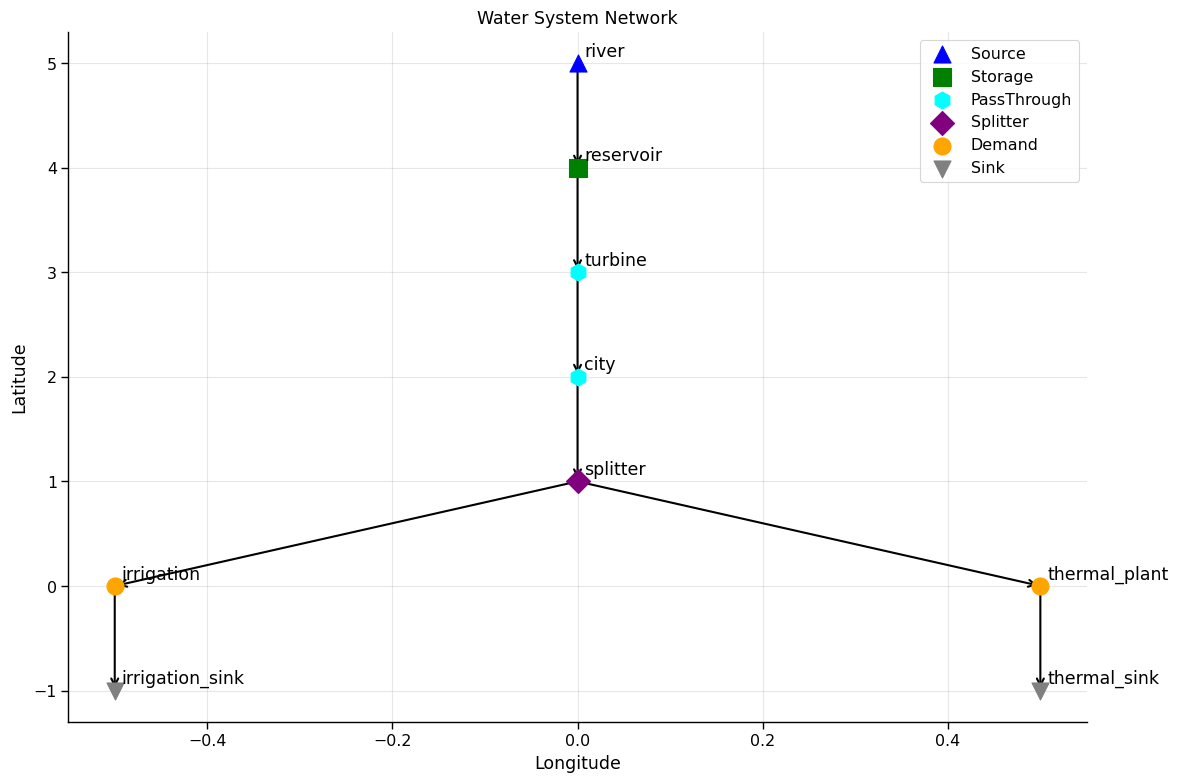

In [10]:
system.visualize()

## Multi-Objective Optimization with NSGA-II

### Why Not Just Optimize One Thing?

In single-objective optimization, there's one "best" answer. But with multiple competing objectives, **there is no single best solution** — only trade-offs.

Consider two solutions:
- **Solution A**: Hydropower = 4.5 GWh, City Flood = 1600
- **Solution B**: Hydropower = 3.0 GWh, City Flood = 900

Which is better? **Neither dominates the other** — A has more power, B has less flooding. The choice depends on what the decision-maker values.

### Pareto Dominance

Solution X **dominates** solution Y if:
1. X is at least as good as Y in ALL objectives
2. X is strictly better than Y in AT LEAST ONE objective

Solutions that are **not dominated by any other** form the **Pareto front**.

### NSGA-II Algorithm

**NSGA-II** (Non-dominated Sorting Genetic Algorithm II) is a popular multi-objective optimizer:

```
1. Initialize random population of solutions
2. Evaluate all solutions on all objectives
3. Repeat for N generations:
   a. Sort population by Pareto rank (non-dominated = rank 0)
   b. Select parents preferring lower rank and higher crowding distance
   c. Create offspring via crossover and mutation
   d. Combine parents + offspring, keep best N solutions
4. Return final Pareto front
```

**Key concepts:**
- **Population size (100)**: Number of candidate solutions evaluated per generation
- **Generations (50)**: Number of evolutionary cycles
- **Crowding distance**: Encourages diversity along the Pareto front
- **Crossover/Mutation**: Genetic operators that explore the parameter space

### Tracking Convergence

We track optimization progress via:
1. **Pareto front size**: How many non-dominated solutions exist
2. **Objective ranges**: Min/max/mean values on the Pareto front
3. **Hypervolume**: Volume of objective space dominated by the Pareto front (higher = better)

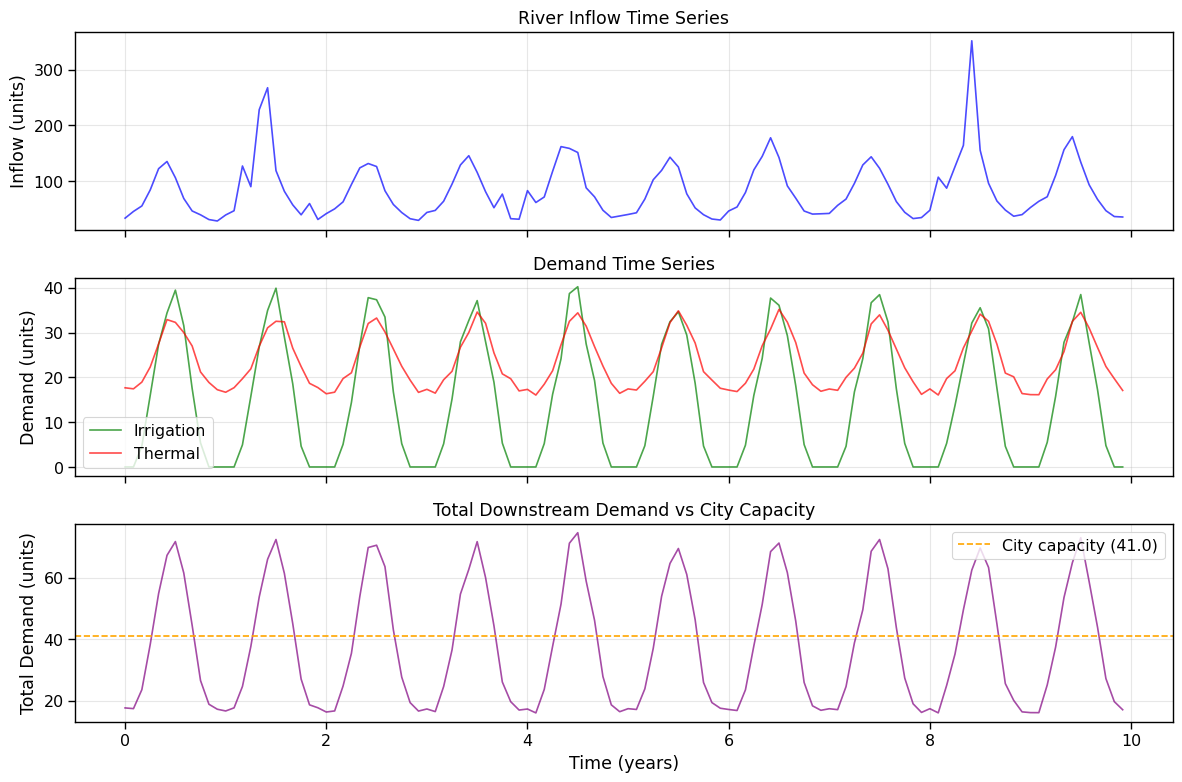

In [11]:
# Visualize input time series
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

months = np.arange(TIMESTEPS)
years = months / 12

axes[0].plot(years, inflows, "b-", alpha=0.7)
axes[0].set_ylabel("Inflow (units)")
axes[0].set_title("River Inflow Time Series")
axes[0].grid(True, alpha=0.3)

axes[1].plot(years, irrigation_demand, "g-", alpha=0.7, label="Irrigation")
axes[1].plot(years, thermal_demand, "r-", alpha=0.7, label="Thermal")
axes[1].set_ylabel("Demand (units)")
axes[1].set_title("Demand Time Series")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(years, [sum(x) for x in zip(irrigation_demand, thermal_demand)], "purple", alpha=0.7)
axes[2].axhline(y=CITY_CAPACITY, color="orange", linestyle="--", label=f"City capacity ({CITY_CAPACITY})")
axes[2].set_ylabel("Total Demand (units)")
axes[2].set_xlabel("Time (years)")
axes[2].set_title("Total Downstream Demand vs City Capacity")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Multi-Objective Optimization

Run NSGA-II to find Pareto-optimal solutions balancing four competing objectives:
- **Maximize** hydropower generation
- **Minimize** city flooding
- **Minimize** irrigation deficit
- **Minimize** thermal plant deficit

The optimizer tunes all 72 parameters (60 SLOP + 12 SeasonalRatio) to explore the trade-off surfaces between power generation, flood risk, and demand satisfaction.

In [12]:
from ctrl_freak import Population
from pymoo.indicators.hv import HV


def make_history_callback(
    objectives: list[Objective],
) -> tuple[callable, dict]:
    """Create callback that collects per-generation Pareto front statistics including hypervolume."""
    # Reference point for hypervolume (must dominate all solutions)
    # All objectives stored in minimize form internally (maximize objectives are negated)
    # [hydropower(negated), city_flood, irrigation_deficit, thermal_deficit, release_variability]
    ref_point = np.array([0.0, 2500.0, 2000.0, 2500.0, 5000.0])  # Added release_variability ref
    hv_indicator = HV(ref_point=ref_point)

    history: dict = {
        "generation": [],
        "n_pareto": [],
        "hypervolume": [],
        "obj_min": {obj.name: [] for obj in objectives},
        "obj_max": {obj.name: [] for obj in objectives},
        "obj_mean": {obj.name: [] for obj in objectives},
    }

    def callback(pop: Population, gen: int) -> bool:
        pareto_mask = pop.rank == 0
        pareto_obj = pop.objectives[pareto_mask]

        history["generation"].append(gen)
        history["n_pareto"].append(int(pareto_mask.sum()))

        # Calculate hypervolume (objectives already in minimize form)
        hv = hv_indicator(pareto_obj)
        history["hypervolume"].append(float(hv))

        for i, obj in enumerate(objectives):
            vals = pareto_obj[:, i].copy()
            if obj.direction == "maximize":
                vals = -vals
            history["obj_min"][obj.name].append(float(vals.min()))
            history["obj_max"][obj.name].append(float(vals.max()))
            history["obj_mean"][obj.name].append(float(vals.mean()))

        return False

    return callback, history

In [13]:
# Reset system for optimization
system.reset()

# Define objectives including the NEW 5th objective for operational smoothness
# The operational_variability_objective combines BOTH release smoothness AND allocation smoothness
objectives_list = [
    hydropower_objective("reservoir", "turbine", initial_storage=75.0),
    flood_objective("city"),
    deficit_objective("irrigation"),
    deficit_objective("thermal_plant"),
    operational_variability_objective("turbine", "irrigation", "thermal_plant"),  # Combined smoothness
]
history_callback, history = make_history_callback(objectives_list)

# Run optimization with 5 objectives
result = optimize(
    system=system,
    objectives=objectives_list,
    timesteps=TIMESTEPS,
    pop_size=200,
    generations=100,
    seed=SEED,
    verbose=True,
    callback=history_callback,
)

print(f"\nOptimization complete!")
print(f"Found {len(result.solutions)} Pareto-optimal solutions")

Gen    0 | Pareto: 102 | hydropower=1.7766, city_flood=1436.5153, irrigation_deficit=713.7073, thermal_plant_deficit=880.5972, operational_variability=4395.4338
Gen    1 | Pareto: 123 | hydropower=3.1561, city_flood=1602.7477, irrigation_deficit=323.5384, thermal_plant_deficit=1449.4291, operational_variability=3411.4245
Gen    2 | Pareto: 153 | hydropower=3.1561, city_flood=1602.7477, irrigation_deficit=323.5384, thermal_plant_deficit=1449.4291, operational_variability=3411.4245
Gen    3 | Pareto: 170 | hydropower=3.1561, city_flood=1602.7477, irrigation_deficit=323.5384, thermal_plant_deficit=1449.4291, operational_variability=3411.4245
Gen    4 | Pareto: 200 | hydropower=1.5821, city_flood=1127.3621, irrigation_deficit=632.5598, thermal_plant_deficit=906.1174, operational_variability=4523.6143
Gen    5 | Pareto: 200 | hydropower=1.8736, city_flood=996.0470, irrigation_deficit=641.7287, thermal_plant_deficit=1001.8166, operational_variability=6110.4880
Gen    6 | Pareto: 200 | hydrop

## Optimization Convergence

### How to Read Convergence Plots

Convergence plots show whether the optimization is working and when to stop:

**1. Pareto Front Size**
- Should grow initially as the algorithm discovers non-dominated solutions
- Eventually stabilizes when the front is well-populated
- Maximum = population size (100 in our case)

**2. Objective Ranges (min-max bands)**
- The **band width** shows diversity on the Pareto front
- **Min values** should improve (decrease for minimize, increase for maximize)
- If bands keep changing significantly, optimization hasn't converged

**3. Hypervolume**
- Single metric summarizing Pareto front quality
- **Higher = better** (more of objective space is dominated)
- Should increase monotonically and eventually plateau
- Rapid early growth → good exploration
- Flattening → convergence achieved

### Reference Point for Hypervolume

Hypervolume requires a **reference point** that is dominated by all Pareto solutions. We use conservative values worse than any expected solution:

| Objective | Reference Value | Rationale |
|-----------|-----------------|-----------|
| Hydropower | 0.0 GWh | Worst possible (no generation) |
| City Flood | 2500 | Well above observed maximum |
| Irrigation Deficit | 2000 | Above maximum demand |
| Thermal Deficit | 2500 | Above maximum demand |

In [20]:
# Extract all objective scores including the new combined smoothness objective
hp = np.array([s.scores["hydropower"] for s in result.solutions])
fl = np.array([s.scores["city_flood"] for s in result.solutions])
irr_def = np.array([s.scores["irrigation_deficit"] for s in result.solutions])
therm_def = np.array([s.scores["thermal_plant_deficit"] for s in result.solutions])
op_var = np.array([s.scores["operational_variability"] for s in result.solutions])  # Combined smoothness

# Summary statistics for all 5 objectives
print("=== Pareto Front Statistics (5 Objectives) ===\n")
print(f"{'Objective':<28} {'Min':>10} {'Max':>10} {'Range':>10}")
print("-" * 60)
print(f"{'Hydropower (GWh)':<28} {hp.min():>10.2f} {hp.max():>10.2f} {hp.max() - hp.min():>10.2f}")
print(f"{'City Flood':<28} {fl.min():>10.1f} {fl.max():>10.1f} {fl.max() - fl.min():>10.1f}")
print(f"{'Irrigation Deficit':<28} {irr_def.min():>10.1f} {irr_def.max():>10.1f} {irr_def.max() - irr_def.min():>10.1f}")
print(f"{'Thermal Deficit':<28} {therm_def.min():>10.1f} {therm_def.max():>10.1f} {therm_def.max() - therm_def.min():>10.1f}")
print(f"{'Operational Variability':<28} {op_var.min():>10.1f} {op_var.max():>10.1f} {op_var.max() - op_var.min():>10.1f}")

print(f"\nTotal Pareto-optimal solutions: {len(result.solutions)}")
print("\nNote: Operational Variability = release variability + allocation variability")
print("      Lower values = smoother releases AND smoother irrigation/thermal splits")

=== Pareto Front Statistics (5 Objectives) ===

Objective                           Min        Max      Range
------------------------------------------------------------
Hydropower (GWh)                   1.26       4.79       3.53
City Flood                        628.3     2077.8     1449.5
Irrigation Deficit                102.9     1468.4     1365.5
Thermal Deficit                     1.7     2222.8     2221.2
Operational Variability          1037.4     9455.1     8417.7

Total Pareto-optimal solutions: 200

Note: Operational Variability = release variability + allocation variability
      Lower values = smoother releases AND smoother irrigation/thermal splits


## Interpreting Pairwise Pareto Fronts (5 Objectives)

When we have 5 objectives, we can't visualize the full 5D Pareto front directly. Instead, we project it onto 2D pairs.

### What to Look For

**1. Shape of the scatter**

| Pattern | Interpretation |
|---------|---------------|
| **Clear front/curve** | Direct trade-off between these two objectives |
| **Scattered cloud** | No direct relationship; trade-off mediated by other objectives |
| **Tight cluster** | Objectives can be satisfied simultaneously |

**2. Color encoding**

We color points by a third objective (often Release Variability) to see 3-way relationships.

### Expected Patterns with Smoothness

| Plot | Expected Pattern | Why |
|------|-----------------|-----|
| Hydropower vs Variability | **Potential trade-off** | High power may need variable releases to exploit conditions |
| Flood vs Variability | **Complex** | Smooth could mean conservative OR aggressive |
| Deficits vs Variability | **Trade-off** | Variable release may adapt better to demands |
| Original pairs | **Similar to 4-obj** | But now colored by smoothness for insight |

### Correlation Matrix

The correlation between objectives on the Pareto front tells us:
- **Strong negative correlation (-1)**: Direct trade-off
- **Near zero correlation**: Independent or complex relationship
- **Strong positive correlation (+1)**: Objectives align (unusual on Pareto front)

**New correlations to watch**: How does Release Variability correlate with each original objective?

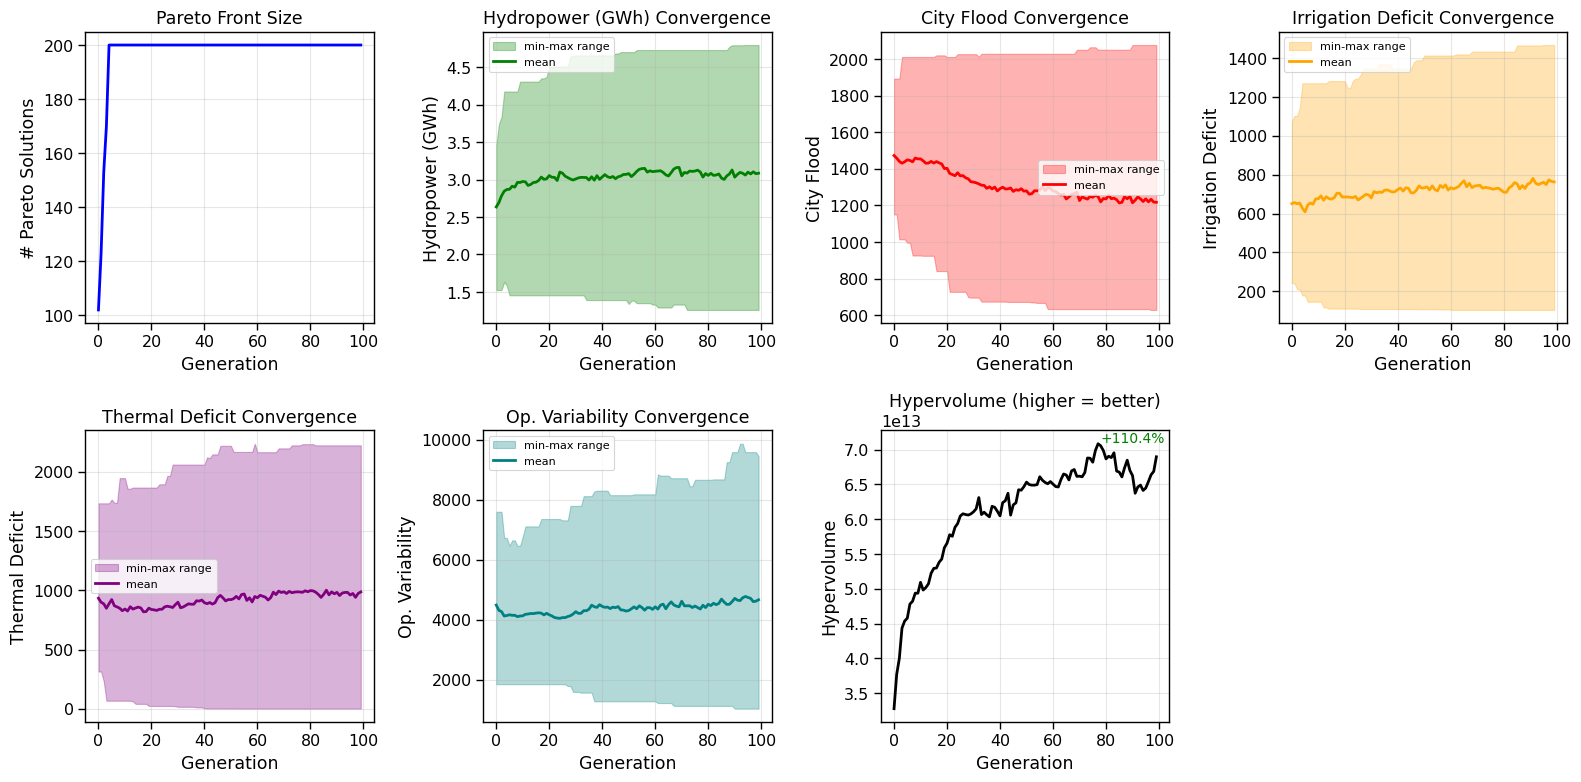


=== Final Generation Statistics ===
Pareto front size: 200 solutions
Hypervolume: 6.90e+13 (improved 110.4% from gen 0)
Hydropower (GWh): 1.26 - 4.79 (mean: 3.08)
City Flood: 628.26 - 2077.78 (mean: 1217.30)
Irrigation Deficit: 102.92 - 1468.39 (mean: 762.70)
Thermal Deficit: 1.65 - 2222.84 (mean: 986.45)
Op. Variability: 1037.40 - 9455.09 (mean: 4667.66)


In [21]:
# Plot optimization convergence for 5 objectives
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
gens = history["generation"]

# Plot 1: Pareto front size
ax = axes[0, 0]
ax.plot(gens, history["n_pareto"], "b-", linewidth=2)
ax.set_xlabel("Generation")
ax.set_ylabel("# Pareto Solutions")
ax.set_title("Pareto Front Size")
ax.grid(True, alpha=0.3)

# Plot 2-6: Objective convergence with min/max bands (now 5 objectives)
obj_names = ["hydropower", "city_flood", "irrigation_deficit", "thermal_plant_deficit", "operational_variability"]
obj_labels = ["Hydropower (GWh)", "City Flood", "Irrigation Deficit", "Thermal Deficit", "Op. Variability"]
colors = ["green", "red", "orange", "purple", "teal"]

for i, (obj_name, label, color) in enumerate(zip(obj_names, obj_labels, colors)):
    if i < 3:
        ax = axes[0, i + 1]
    else:
        ax = axes[1, i - 3]

    obj_min = history["obj_min"][obj_name]
    obj_max = history["obj_max"][obj_name]
    obj_mean = history["obj_mean"][obj_name]

    ax.fill_between(gens, obj_min, obj_max, alpha=0.3, color=color, label="min-max range")
    ax.plot(gens, obj_mean, color=color, linewidth=2, label="mean")
    ax.set_xlabel("Generation")
    ax.set_ylabel(label)
    ax.set_title(f"{label} Convergence")
    ax.legend(loc="best", fontsize=8)
    ax.grid(True, alpha=0.3)

# Plot 7: Hypervolume
ax = axes[1, 2]
ax.plot(gens, history["hypervolume"], "k-", linewidth=2)
ax.set_xlabel("Generation")
ax.set_ylabel("Hypervolume")
ax.set_title("Hypervolume (higher = better)")
ax.grid(True, alpha=0.3)
# Add percentage improvement annotation
hv_start = history["hypervolume"][0]
hv_end = history["hypervolume"][-1]
improvement = (hv_end - hv_start) / hv_start * 100
ax.annotate(f"+{improvement:.1f}%", xy=(gens[-1], hv_end), xytext=(-40, 10),
            textcoords="offset points", fontsize=10, color="green")

# Hide unused subplot
axes[1, 3].axis("off")

plt.tight_layout()
plt.show()

# Print final statistics
print("\n=== Final Generation Statistics ===")
print(f"Pareto front size: {history['n_pareto'][-1]} solutions")
print(f"Hypervolume: {history['hypervolume'][-1]:.2e} (improved {improvement:.1f}% from gen 0)")
for obj_name, label in zip(obj_names, obj_labels):
    print(f"{label}: {history['obj_min'][obj_name][-1]:.2f} - {history['obj_max'][obj_name][-1]:.2f} (mean: {history['obj_mean'][obj_name][-1]:.2f})")

## Parallel Coordinates: Seeing All 5 Objectives at Once

### What is a Parallel Coordinates Plot?

Unlike scatter plots that show 2 dimensions, parallel coordinates display **many dimensions simultaneously**:
- Each vertical axis represents one objective
- Each line represents one Pareto solution
- The line connects the solution's value on each axis

### How to Read It (5 Objectives)

1. **Crossing lines** = trade-off (good on one axis means bad on another)
2. **Parallel lines** = objectives that correlate (can be optimized together)
3. **Line bundles** = groups of similar solutions

### The 5th Dimension: Operational Variability

The **Operational Variability** axis shows combined smoothness:
- **Low values (top)** = smooth releases AND smooth allocation
- **High values (bottom)** = erratic releases OR erratic allocation (or both)

**Key insight**: This metric captures BOTH types of operational chaos:
- Wild swings in how much water is released from the reservoir
- Wild swings in how that water is split between irrigation and thermal

### Interactive Features

The Plotly version allows **filtering**:
1. **Click and drag** on any axis to select a range
2. Lines outside the range are grayed out
3. **Combine filters** across multiple axes to find specific solutions

**Example queries for smoothness:**
- "Show me solutions with Op. Variability < 2000" → operationally realistic only
- "What's the best hydropower among smooth solutions?" → filter variability, observe power
- "Does smoothness correlate with irrigation deficit?" → filter one, observe the other

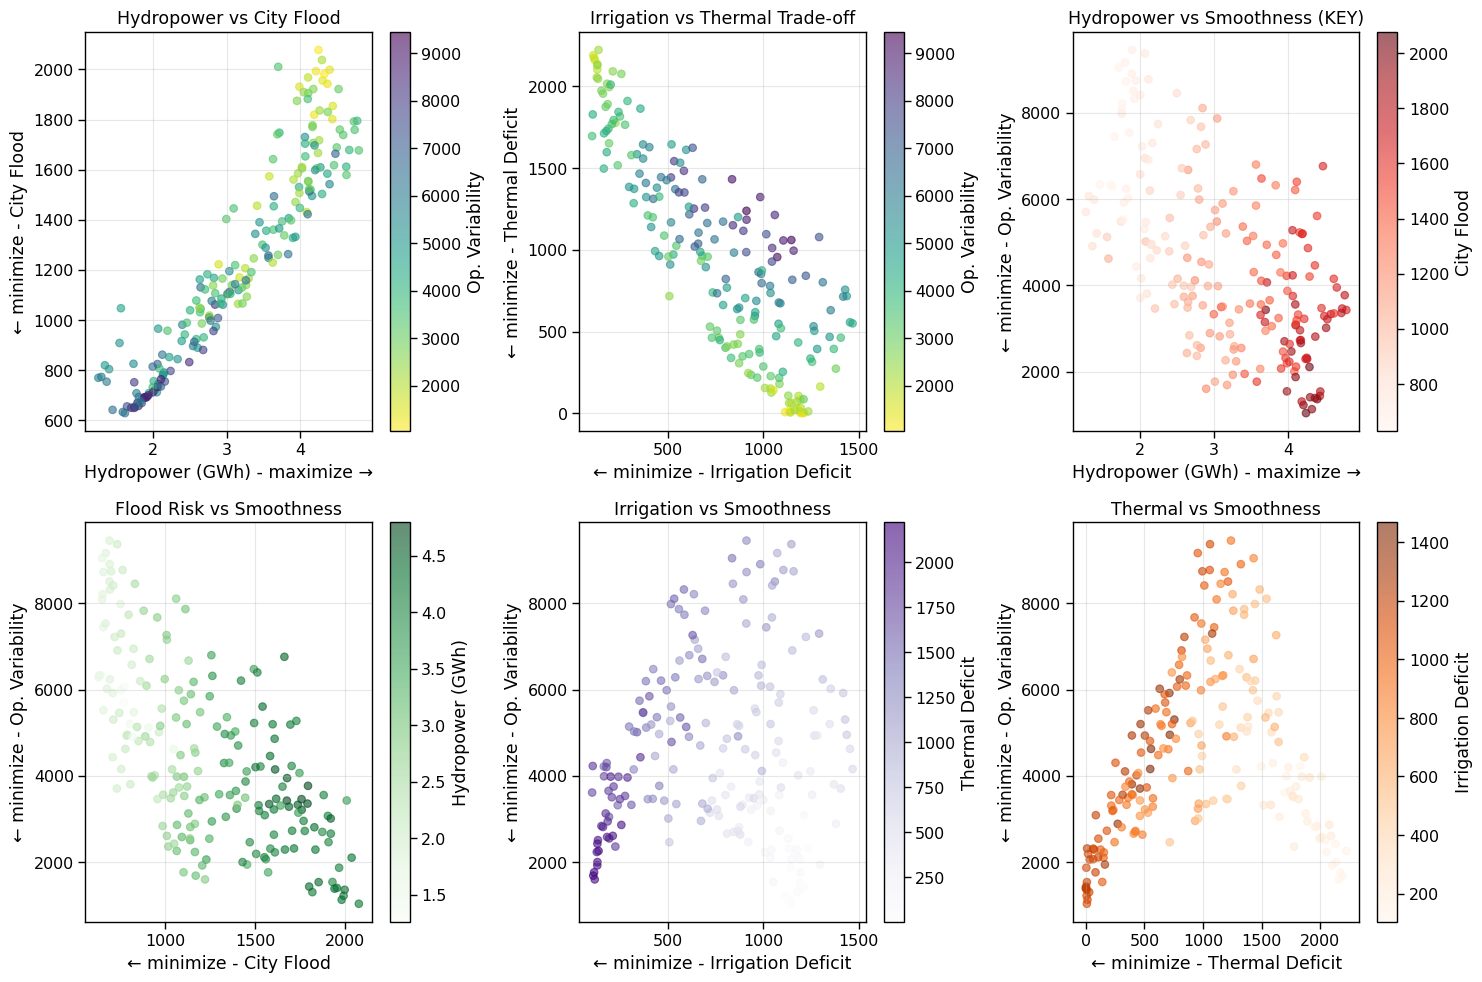


=== Objective Correlations (5 Objectives) ===

                      Hydropower      City Flood    Irr. Deficit  Therm. Deficit Op. Variability
      Hydropower            1.00            0.93           -0.11           -0.30           -0.61
      City Flood            0.93            1.00           -0.01           -0.43           -0.67
    Irr. Deficit           -0.11           -0.01            1.00           -0.85            0.08
  Therm. Deficit           -0.30           -0.43           -0.85            1.00            0.23
 Op. Variability           -0.61           -0.67            0.08            0.23            1.00


In [22]:
# Create 2x3 grid of pairwise Pareto projections including operational variability
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Hydropower vs City Flood (original trade-off)
ax = axes[0, 0]
scatter = ax.scatter(hp, fl, s=30, alpha=0.6, c=op_var, cmap="viridis_r")
ax.set_xlabel("Hydropower (GWh) - maximize →")
ax.set_ylabel("← minimize - City Flood")
ax.set_title("Hydropower vs City Flood")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Op. Variability")

# Plot 2: Irrigation vs Thermal Deficit (splitter trade-off)
ax = axes[0, 1]
scatter = ax.scatter(irr_def, therm_def, s=30, alpha=0.6, c=op_var, cmap="viridis_r")
ax.set_xlabel("← minimize - Irrigation Deficit")
ax.set_ylabel("← minimize - Thermal Deficit")
ax.set_title("Irrigation vs Thermal Trade-off")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Op. Variability")

# Plot 3: Hydropower vs Operational Variability (KEY: combined smoothness trade-off)
ax = axes[0, 2]
scatter = ax.scatter(hp, op_var, s=30, alpha=0.6, c=fl, cmap="Reds")
ax.set_xlabel("Hydropower (GWh) - maximize →")
ax.set_ylabel("← minimize - Op. Variability")
ax.set_title("Hydropower vs Smoothness (KEY)")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("City Flood")

# Plot 4: City Flood vs Operational Variability
ax = axes[1, 0]
scatter = ax.scatter(fl, op_var, s=30, alpha=0.6, c=hp, cmap="Greens")
ax.set_xlabel("← minimize - City Flood")
ax.set_ylabel("← minimize - Op. Variability")
ax.set_title("Flood Risk vs Smoothness")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Hydropower (GWh)")

# Plot 5: Irrigation Deficit vs Operational Variability
ax = axes[1, 1]
scatter = ax.scatter(irr_def, op_var, s=30, alpha=0.6, c=therm_def, cmap="Purples")
ax.set_xlabel("← minimize - Irrigation Deficit")
ax.set_ylabel("← minimize - Op. Variability")
ax.set_title("Irrigation vs Smoothness")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Thermal Deficit")

# Plot 6: Thermal Deficit vs Operational Variability
ax = axes[1, 2]
scatter = ax.scatter(therm_def, op_var, s=30, alpha=0.6, c=irr_def, cmap="Oranges")
ax.set_xlabel("← minimize - Thermal Deficit")
ax.set_ylabel("← minimize - Op. Variability")
ax.set_title("Thermal vs Smoothness")
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Irrigation Deficit")

plt.tight_layout()
plt.show()

# Correlation matrix for 5 objectives
print("\n=== Objective Correlations (5 Objectives) ===")
objectives_matrix = np.column_stack([hp, fl, irr_def, therm_def, op_var])
corr = np.corrcoef(objectives_matrix.T)
labels = ["Hydropower", "City Flood", "Irr. Deficit", "Therm. Deficit", "Op. Variability"]
print(f"\n{'':>16}", end="")
for label in labels:
    print(f"{label:>16}", end="")
print()
for i, row_label in enumerate(labels):
    print(f"{row_label:>16}", end="")
    for j in range(len(labels)):
        print(f"{corr[i, j]:>16.2f}", end="")
    print()

## Water Availability Over Time: Seeing the Strategies in Action

### From Numbers to Understanding

The Pareto front shows us **what** trade-offs exist, but not **how** they arise. Time series visualizations reveal **why** different solutions perform differently.

### Four Representative Strategies (including Smoothest)

We select four solutions from different regions of the Pareto front:

| Strategy | Philosophy | Expected Behavior |
|----------|------------|-------------------|
| **Smoothest** | Minimize variability, stable operations | Consistent release pattern, may sacrifice performance |
| **Low Flood Risk** | Conservative release, prioritize safety | Low reservoir releases, less flooding at city |
| **Balanced** | Middle ground | Moderate releases, accepts some flooding and deficits |
| **High Power** | Aggressive release, maximize energy | High releases, more flooding, may be erratic |

### What to Look For

**1. Turbine Flow (KEY for smoothness comparison)**
- Compare the "Smoothest" line to others
- How much more consistent is the smooth solution?
- What performance does it sacrifice?

**2. Reservoir Storage**
- Does it hit capacity (150 units)? → Spillage at reservoir
- Does it hit dead storage (10 units)? → No water available
- Does the smoothest solution have gentler storage swings?

**3. Deficit Patterns**
- Does smooth operation lead to more deficits?
- Or can smooth solutions still meet demands?

**4. Trade-off Visibility**
- The time series make the smoothness trade-off **tangible**
- Students can see what "release variability" actually means

In [23]:
# Create DataFrame with all 5 objective scores
df_pareto = pd.DataFrame({
    "Hydropower (GWh)": hp,
    "City Flood": fl,
    "Irrigation Deficit": irr_def,
    "Thermal Deficit": therm_def,
    "Op. Variability": op_var,  # Combined smoothness metric
})

# Interactive parallel coordinates plot with Plotly - now with 5 dimensions
fig = px.parallel_coordinates(
    df_pareto,
    color="Op. Variability",  # Color by combined smoothness to highlight the new dimension
    color_continuous_scale="Viridis_r",  # Reversed so lower (smoother) = brighter
    dimensions=["Hydropower (GWh)", "City Flood", "Irrigation Deficit", "Thermal Deficit", "Op. Variability"],
    title=" ",
)

fig.update_layout(
    height=500,
    margin=dict(l=80, r=80, t=50, b=30),
)

fig.show()

# Also show one colored by hydropower for comparison
fig2 = px.parallel_coordinates(
    df_pareto,
    color="Hydropower (GWh)",
    color_continuous_scale="Viridis",
    dimensions=["Hydropower (GWh)", "City Flood", "Irrigation Deficit", "Thermal Deficit", "Op. Variability"],
    title=" ",
)

fig2.update_layout(
    height=500,
    margin=dict(l=80, r=80, t=50, b=30),
)

fig2.show()

## Summary and Key Takeaways

### What We Learned

1. **Operational smoothness has a cost**
   - The smoothest solutions sacrifice performance on other objectives
   - This trade-off is now **visible** in the Pareto front
   - Decision-makers can choose their preferred balance

2. **Two types of variability matter**
   - **Release variability**: How much the turbine flow changes month-to-month
   - **Allocation variability**: How much the irrigation/thermal split changes
   - The combined metric captures BOTH operational concerns

3. **5 objectives are still visualizable**
   - Parallel coordinates handles 5 dimensions well
   - Pairwise projections show key relationships
   - The "smoothness vs performance" trade-off is clearly visible

4. **Trade-offs with smoothness**
   - Hydropower ↔ Smoothness: High power may require variable releases
   - Deficits ↔ Smoothness: Meeting demands perfectly may require allocation swings
   - Stable allocation may mean accepting some deficit

### The Combined Smoothness Metric

```
Operational Variability = Σ|R(t) - R(t-1)| + Σ|frac(t) - frac(t-1)|×100
                          └─── release ───┘   └─── allocation ────────┘
```

This single objective captures both operational concerns, allowing the optimizer to find solutions that are smooth in **all** dimensions of operation.

### Practical Implications

In real-world reservoir operations:
1. **Filter by smoothness first**: Set a maximum acceptable variability
2. Solutions with low variability are more likely to be **implementable**
3. The breakdown shows which type of variability dominates each solution
4. Operators can prioritize release smoothness vs allocation smoothness

### What to Look For in the Time Series

When examining the "Smoothest" solution:
- Turbine flow should show gentler month-to-month changes
- Irrigation/thermal split should be more consistent
- Trade-off: may accept more deficit or less power for stability

In [24]:
def simulate_and_extract_traces(
    solution, timesteps: int, initial_storage: float = 75.0
) -> dict[str, np.ndarray]:
    """Apply solution parameters, simulate, and extract key traces."""
    # Create a new system with the solution's optimized parameters
    sys = solution.to_system()
    sys.simulate(timesteps)

    # Extract traces as arrays (filling missing timesteps with 0)
    def trace_to_array(trace, timesteps: int) -> np.ndarray:
        return np.array([trace.get(t, 0.0) for t in range(timesteps)])

    reservoir = sys.nodes["reservoir"]
    turbine = sys.nodes["turbine"]
    city = sys.nodes["city"]
    irrigation = sys.nodes["irrigation"]
    thermal = sys.nodes["thermal_plant"]

    # Compute reservoir storage over time
    stored = trace_to_array(reservoir.trace(WaterStored), timesteps)
    released = trace_to_array(reservoir.trace(WaterReleased), timesteps)
    net_change = stored - released
    storage = np.cumsum(net_change) + initial_storage

    return {
        "reservoir_storage": storage,
        "turbine_flow": trace_to_array(turbine.trace(WaterPassedThrough), timesteps),
        "city_flow": trace_to_array(city.trace(WaterPassedThrough), timesteps),
        "city_spill": trace_to_array(city.trace(WaterSpilled), timesteps),
        "irrigation_received": trace_to_array(irrigation.trace(WaterReceived), timesteps),
        "irrigation_deficit": trace_to_array(irrigation.trace(DeficitRecorded, field="deficit"), timesteps),
        "thermal_received": trace_to_array(thermal.trace(WaterReceived), timesteps),
        "thermal_deficit": trace_to_array(thermal.trace(DeficitRecorded, field="deficit"), timesteps),
    }


# Select representative solutions - now considering combined operational variability
min_flood_idx = np.argmin(fl)
max_hp_idx = np.argmax(hp)
min_var_idx = np.argmin(op_var)  # Smoothest solution (both release AND allocation)

# Balanced: sort by hydropower, pick middle
sort_idx = np.argsort(hp)
balanced_idx = sort_idx[len(sort_idx) // 2]

solutions_to_plot = [
    ("Smoothest", result.solutions[min_var_idx], "C3"),  # Smoothest in BOTH dimensions
    ("Low Flood Risk", result.solutions[min_flood_idx], "C0"),
    ("Balanced", result.solutions[balanced_idx], "C2"),
    ("High Power", result.solutions[max_hp_idx], "C1"),
]

# Print solution characteristics including operational variability
print("=== Selected Solutions (5 Objectives) ===\n")
print(f"{'Strategy':<18} {'Hydropower':>12} {'City Flood':>12} {'Irr. Deficit':>14} {'Therm. Deficit':>15} {'Op. Var':>10}")
print("-" * 85)
for name, sol, _ in solutions_to_plot:
    print(
        f"{name:<18} "
        f"{sol.scores['hydropower']:>12.2f} "
        f"{sol.scores['city_flood']:>12.1f} "
        f"{sol.scores['irrigation_deficit']:>14.1f} "
        f"{sol.scores['thermal_plant_deficit']:>15.1f} "
        f"{sol.scores['operational_variability']:>10.1f}"
    )

print("\nNote: 'Smoothest' now minimizes BOTH release variability AND allocation variability")

=== Selected Solutions (5 Objectives) ===

Strategy             Hydropower   City Flood   Irr. Deficit  Therm. Deficit    Op. Var
-------------------------------------------------------------------------------------
Smoothest                  4.25       2077.8         1143.2             9.9     1037.4
Low Flood Risk             1.62        628.3          538.9          1371.5     6286.0
Balanced                   3.16       1119.4         1348.2           468.0     5201.7
High Power                 4.79       1677.0          480.9          1087.4     3427.7

Note: 'Smoothest' now minimizes BOTH release variability AND allocation variability


In [26]:
# Simulate each solution and collect traces (now 4 solutions including smoothest)
all_traces = {}
for name, sol, color in solutions_to_plot:
    all_traces[name] = simulate_and_extract_traces(sol, TIMESTEPS)

# Create INTERACTIVE visualization with Plotly (click legend to show/hide solutions)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

years = np.arange(TIMESTEPS) / 12

# Color mapping for consistency
color_map = {
    "Smoothest": "#d62728",      # C3 - red
    "Low Flood Risk": "#1f77b4", # C0 - blue  
    "Balanced": "#2ca02c",       # C2 - green
    "High Power": "#ff7f0e",     # C1 - orange
}

fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=(
        "Reservoir Storage Over Time",
        "Flow Through Turbine (observe smoothness differences!)",
        "Irrigation: Water Received vs Required",
        "Thermal Plant: Water Received vs Required"
    )
)

# Plot 1: Reservoir Storage
for name, sol, _ in solutions_to_plot:
    fig.add_trace(go.Scatter(
        x=years, y=all_traces[name]["reservoir_storage"],
        name=name, legendgroup=name,
        line=dict(color=color_map[name]),
        showlegend=True
    ), row=1, col=1)

# Reference lines for storage
fig.add_hline(y=150, line_dash="dash", line_color="red", opacity=0.5, row=1, col=1)
fig.add_hline(y=10, line_dash="dash", line_color="orange", opacity=0.5, row=1, col=1)

# Plot 2: Turbine Flow
for name, sol, _ in solutions_to_plot:
    fig.add_trace(go.Scatter(
        x=years, y=all_traces[name]["turbine_flow"],
        name=name, legendgroup=name,
        line=dict(color=color_map[name]),
        showlegend=False  # Already in legend from plot 1
    ), row=2, col=1)

# Reference lines for capacity
fig.add_hline(y=60, line_dash="dash", line_color="blue", opacity=0.5, row=2, col=1)
fig.add_hline(y=CITY_CAPACITY, line_dash="dash", line_color="red", opacity=0.5, row=2, col=1)

# Plot 3: Irrigation
# Add required demand as filled area
fig.add_trace(go.Scatter(
    x=years, y=irrigation_demand,
    fill='tozeroy', fillcolor='rgba(128,128,128,0.2)',
    line=dict(color='rgba(128,128,128,0.5)'),
    name='Required', legendgroup='required',
    showlegend=True
), row=3, col=1)

for name, sol, _ in solutions_to_plot:
    fig.add_trace(go.Scatter(
        x=years, y=all_traces[name]["irrigation_received"],
        name=name, legendgroup=name,
        line=dict(color=color_map[name]),
        showlegend=False
    ), row=3, col=1)

# Plot 4: Thermal Plant
fig.add_trace(go.Scatter(
    x=years, y=thermal_demand,
    fill='tozeroy', fillcolor='rgba(128,128,128,0.2)',
    line=dict(color='rgba(128,128,128,0.5)'),
    name='Required', legendgroup='required',
    showlegend=False
), row=4, col=1)

for name, sol, _ in solutions_to_plot:
    fig.add_trace(go.Scatter(
        x=years, y=all_traces[name]["thermal_received"],
        name=name, legendgroup=name,
        line=dict(color=color_map[name]),
        showlegend=False
    ), row=4, col=1)

# Update layout
fig.update_layout(
    height=900,
    title_text="Time Series Comparison (click legend to show/hide solutions)",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    hovermode="x unified"
)

# Update axes labels
fig.update_yaxes(title_text="Storage (units)", row=1, col=1)
fig.update_yaxes(title_text="Flow (units)", row=2, col=1)
fig.update_yaxes(title_text="Water (units)", row=3, col=1)
fig.update_yaxes(title_text="Water (units)", row=4, col=1)
fig.update_xaxes(title_text="Time (years)", row=4, col=1)

fig.show()

# Calculate and display BOTH components of operational variability for each solution
print("\n=== Operational Variability Breakdown ===")
print("(Lower = smoother, more operationally realistic)")
print()
print(f"{'Strategy':<18} {'Release Var':>12} {'Alloc. Var':>12} {'Total':>10}")
print("-" * 55)
for name, sol, color in solutions_to_plot:
    flows = all_traces[name]["turbine_flow"]
    irr = all_traces[name]["irrigation_received"]
    therm = all_traces[name]["thermal_received"]
    
    # Release variability
    release_var = np.sum(np.abs(np.diff(flows)))
    
    # Allocation variability (irrigation fraction)
    total = irr + therm
    with np.errstate(divide='ignore', invalid='ignore'):
        irr_frac = np.where(total > 0, irr / total, 0.5)
    alloc_var = np.sum(np.abs(np.diff(irr_frac))) * 100  # Scaled same as objective
    
    print(f"{name:18}: {release_var:>12.1f} {alloc_var:>12.1f} {release_var + alloc_var:>10.1f}")


=== Operational Variability Breakdown ===
(Lower = smoother, more operationally realistic)

Strategy            Release Var   Alloc. Var      Total
-------------------------------------------------------
Smoothest         :        191.3        846.1     1037.4
Low Flood Risk    :       2342.2       3943.7     6286.0
Balanced          :       1516.6       3685.2     5201.7
High Power        :        657.5       2770.2     3427.7
